# 第2章　音声処理の基本

## 第1節　音声ファイルを聞いてみよう

### 音声ファイルを開く

In [98]:
import wave
import pyroomacoustics as pa
import numpy as np 

pa.datasets.CMUArcticCorpus(basedir="./CMU_ARCTIC",download=True,speaker=["aew","axb"])
sample_wave_file="./CMU_ARCTIC/cmu_us_aew_arctic/wav/arctic_a0001.wav"
wav=wave.open(sample_wave_file)

print("サンプリング周波数[Hz]: ",wav.getframerate())
print("サンプルサイズ[Byte]: ",wav.getsampwidth())
print("サンプル数: ",wav.getnframes())
print("チャンネル数: ",wav.getnchannels())

data=wav.readframes(wav.getnframes())
data=np.frombuffer(data,dtype=np.int16)

wav.close()

サンプリング周波数[Hz]:  16000
サンプルサイズ[Byte]:  2
サンプル数:  62081
チャンネル数:  1


### 音声ファイルをグラフ化する

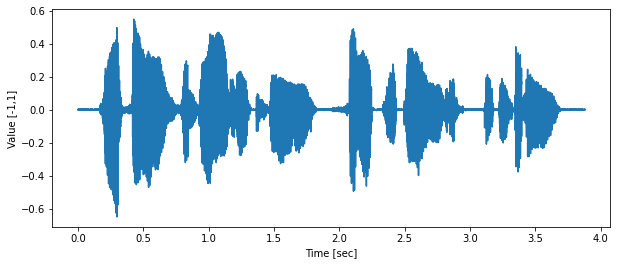

In [97]:
import matplotlib.pyplot as plt

data=data/np.iinfo(np.int16).max
x=np.array(range(wav.getnframes()))/wav.getframerate()

plt.figure(figsize=(10,4))
plt.xlabel("Time [sec]")
plt.ylabel("Value [-1,1]")

plt.plot(x,data)

plt.savefig("./wave_form.png")

plt.show()

### 白色雑音をグラフ化する

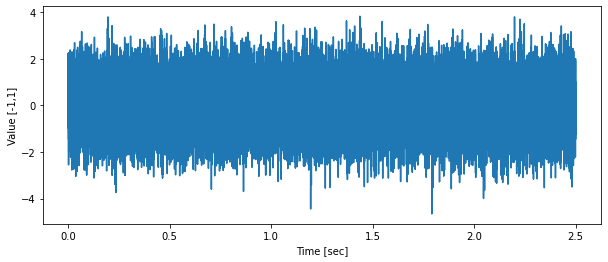

In [38]:
n_sample=40000
sample_rate=16000
np.random.seed(0)
data=np.random.normal(size=n_sample)

x=np.array(range(n_sample))/sample_rate

plt.figure(figsize=(10,4))
plt.xlabel("Time [sec]")
plt.ylabel("Value [-1,1]")

plt.plot(x,data)

plt.show()

### ファイルに音声データを書き込む

In [99]:
np.random.seed(0)
np.random.normal(scale=0.1,size=n_sample)
data_scale_adjust=data*np.iinfo(np.int16).max
data_scale_adjust=data_scale_adjust.astype(np.int16)
wave_out=wave.open("./wgn_wave.wav",'w')
wave_out.setnchannels(1)
wave_out.setsampwidth(2)
wave_out.setframerate(sample_rate)
wave_out.writeframes(data_scale_adjust)
wave_out.close()

### 音声ファイルを再生する

In [100]:
import sounddevice as sd 

sd.play(data,wav.getframerate())
print("再生開始")
status=sd.wait()

再生開始


## 第2節　時間周波数領域への変換

### 音声データを録音する

In [35]:
wave_length=5
sample_rate=16000
print("録音開始")
data=sd.rec(frames=int(wave_length*sample_rate),samplerate=sample_rate,channels=1)
sd.wait()

# 録音した音声を再生する
sd.play(data,wav.getframerate())
print("再生開始")
status=sd.wait()

録音開始
再生開始


* フーリエ変換  
時間領域のデータ（時系列のデータ）を周波数領域のデータ（周波数成分の振幅と位相のデータ）に変換する  

* 短時間フーリエ変換（STFT: Short Term Fourier Transform）  
元となるデータを短時間のデータ（フレーム）に区切り、そのデータごとにフーリエ変換を施す  

* フレーム  
短時間の時系列データの一つ一つのこと  

* フレームサイズ  
各フレームの時間幅.フレームは時間方向にフレームサイズの2分の1から4分の3程度オーバーラップさせることが一般的.  

* 窓関数  
切り取ったフレームに窓関数をかけることで、周波数に変換する際に他の周波数が漏れ込む影響を軽減できる  
* ハニング(hanning)窓  
$$
w(n)=0.5-0.5\cos\left(\frac{2\pi n}{N-1}\right) 
$$
* ハミング(hamming)窓  
$$
w(n)=0.54-0.46\cos\left(\frac{2\pi n}{N-1}\right)\\

\left(\begin{eqnarray}n&:& 切り出すフレームの先頭から数えたサンプル数\\N&:& フレームサイズ \quad 0\leq n \leq N-1\end{eqnarray}\right)

$$
* フレームごとの音声波形$x'(l,n)$
$$
x'(l,n)=w(n)x(l \times L_{\mathrm{shift}}+n)\\

\left(\begin{eqnarray}l&:& フレームインデックス.フレームの番号を表す変数\\
L_{\mathrm{shift}}&:& フレームシフト\quad L_{\mathrm{shift}}=0.5N\quad \mathrm{or} \quad 0.25N\\
\end{eqnarray}\right)
$$
* フレームごとの短時間フーリエ変換
$$
y(l,k)=\sum_{n=0}^{N-1}x(l,n)\exp\left(-j\frac{2\pi nk}{N-1}\right)\\
\left(j:虚数単位\quad j=\sqrt{-1}\right)
$$

### Numpyを用いた複素数の四則演算

In [18]:
import numpy as np 

z=1.0+2.0j
u=2.0+3.0j

print('z=',z)
print('u=',u)
print('Real(z)=',np.real(z))
print('Imaginary(z)=',np.imag(z))
# 複素共益
print('z^*=',np.conjugate(z))
# 複素数の絶対値
print('|z|=',np.abs(z))
v=z+u
print('z+u=',v)
v=z-u 
print('z-u=',v)
v=z*u 
print('z*u=',v)
v=z/u 
print('z/u=',v)

z= (1+2j)
u= (2+3j)
Real(z)= 1.0
Imaginary(z)= 2.0
z^*= (1-2j)
|z|= 2.23606797749979
z+u= (3+5j)
z-u= (-1-1j)
z*u= (-4+7j)
z/u= (0.6153846153846154+0.07692307692307691j)


### オイラーの公式
$$
\exp(j\theta)=\cos\theta+j\sin\theta
$$
オイラーの公式を用いると、複素数 $z=x+jy$ を極座標系で書くことができる
$$
z=r\exp(j\theta)\\
(r: zの絶対値\quad r=|z|)
$$
ここで
$$
x=r\cos\theta\\
y=r\sin\theta\\
\left(\begin{eqnarray}\theta&:& 複素数zの位相\\ 
r &:& 複素数zの振幅
\end{eqnarray}\right)
$$
オイラーの公式を用いると
$$
\cos\theta=\frac{\exp(j\theta)+\exp(-j\theta)}{2}\\
\sin\theta=\frac{\exp(j\theta)-\exp(-j\theta)}{2j}
$$
フレーム $l$ における周波数 $f$ の波形
$$
x'(l,n,f)=A_{l,f}\cos\left(\frac{2\pi fn}{F_s}+\theta_{l,f}\right)\\
\left(\begin{eqnarray}A_{l,f}&:& フレームlにおける周波数fの振幅\\
\theta_{l,f}&:& フレームlにおける周波数fの位相\\
F_{s}&:&サンプリング周波数
\end{eqnarray}\right)
$$
ナイキスト周波数 $F_{s}/2$ 以下の様々な周波数成分が混ざった信号（波形）
$$
x'(l,n)=\sum_{f=0}^{\frac{F_s}{2}}A_{l,f}\cos\left(\frac{2\pi fn}{F_s}+\theta_{l,f}\right)
$$

### stftによる短時間フーリエ変換

In [101]:
import scipy.signal as sp 

f,t,stft_data=sp.stft(data,fs=wav.getframerate(),window="hann",nperseg=512,noverlap=256)
print("短時間フーリエ変換後のshape: ",np.shape(stft_data))
print("周波数軸 [Hz]: ",f)
print("時間軸 [sec]: ",t)

短時間フーリエ変換後のshape:  (257, 244)
周波数軸 [Hz]:  [   0.     31.25   62.5    93.75  125.    156.25  187.5   218.75  250.
  281.25  312.5   343.75  375.    406.25  437.5   468.75  500.    531.25
  562.5   593.75  625.    656.25  687.5   718.75  750.    781.25  812.5
  843.75  875.    906.25  937.5   968.75 1000.   1031.25 1062.5  1093.75
 1125.   1156.25 1187.5  1218.75 1250.   1281.25 1312.5  1343.75 1375.
 1406.25 1437.5  1468.75 1500.   1531.25 1562.5  1593.75 1625.   1656.25
 1687.5  1718.75 1750.   1781.25 1812.5  1843.75 1875.   1906.25 1937.5
 1968.75 2000.   2031.25 2062.5  2093.75 2125.   2156.25 2187.5  2218.75
 2250.   2281.25 2312.5  2343.75 2375.   2406.25 2437.5  2468.75 2500.
 2531.25 2562.5  2593.75 2625.   2656.25 2687.5  2718.75 2750.   2781.25
 2812.5  2843.75 2875.   2906.25 2937.5  2968.75 3000.   3031.25 3062.5
 3093.75 3125.   3156.25 3187.5  3218.75 3250.   3281.25 3312.5  3343.75
 3375.   3406.25 3437.5  3468.75 3500.   3531.25 3562.5  3593.75 3625.
 3656.25 3687.5  371

## 第3節　音声を可視化する

### 短時間フーリエ変換で変換した信号のスペクトログラム表示

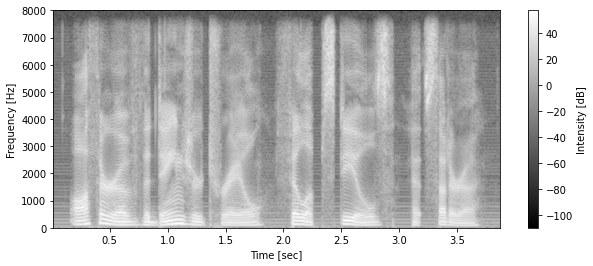

In [102]:
import matplotlib.pyplot as plt 

fig=plt.figure(figsize=(10,4))
spectrum,freqs,t,im=plt.specgram(data,NFFT=512,noverlap=512/16*15,Fs=wav.getframerate(),cmap="gray")
fig.colorbar(im).set_label("Intensity [dB]")
plt.xlabel("Time [sec]")
plt.ylabel("Frequency [Hz]")
plt.savefig("./spectrogram.png")
plt.show()

## 第4節　音声を時間領域の信号に戻す

### 短時間フーリエ逆変換
$$
y'(l,n)=\frac{1}{N}\sum_{k=0}^{N-1}y(l,k)\exp\left(j\frac{2\pi nk}{N}\right)
$$

### 短時間フーリエ逆変換により時間周波数領域の信号を時間領域の信号へ戻す

In [103]:
# stftで指定した窓関数と同じものを指定するのが望ましい
t,data_post=sp.istft(stft_data,fs=wav.getframerate(),window="hann",nperseg=512,noverlap=256)

data_post=data_post.astype(np.int16)
wave_out=wave.open("./istft_post_wave.wav",'w')
wave_out.setnchannels(1)
wave_out.setsampwidth(2)
wave_out.setframerate(wav.getframerate())
wave_out.writeframes(data_post)
wave_out.close()
wav.close()

In [104]:
import sounddevice as sd 
import wave

istft_post_wave=wave.open("./istft_post_wave.wav")
data=istft_post_wave.readframes(istft_post_wave.getnframes())
data=np.frombuffer(data,dtype=np.int16)

sd.play(data,istft_post_wave.getframerate())
print("再生開始")
status=sd.wait()
istft_post_wave.close()

再生開始


## 第5節　時間周波数領域での音声の加工

### 特定の周波数を消した音を再生する

In [70]:
stft_data[100:,:]=0
t,data_post=sp.istft(stft_data,fs=wav.getframerate(),window='hann',nperseg=512,noverlap=256)
data_post=data_post.astype(np.int16)
sd.play(data_post,wav.getframerate())
print("再生開始")
status=sd.wait()
wav.close()

再生開始


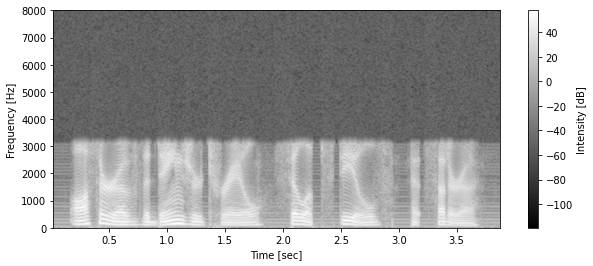

In [71]:
fig=plt.figure(figsize=(10,4))
spectrum,freqs,t,im=plt.specgram(data_post,NFFT=512,noverlap=512/16*15,Fs=wav.getframerate(),cmap="gray")
fig.colorbar(im).set_label("Intensity [dB]")
plt.xlabel("Time [sec]")
plt.ylabel("Frequency [Hz]")
plt.savefig("./spectrogram.png")
plt.show()

### 特定の周波数を消した音を再生する

In [105]:
stft_data[:50,:]=0
t,data_post=sp.istft(stft_data,fs=wav.getframerate(),window='hann',nperseg=512,noverlap=256)
data_post=data_post.astype(np.int16)
sd.play(data_post,wav.getframerate())
print("再生開始")
status=sd.wait()
wav.close()

再生開始


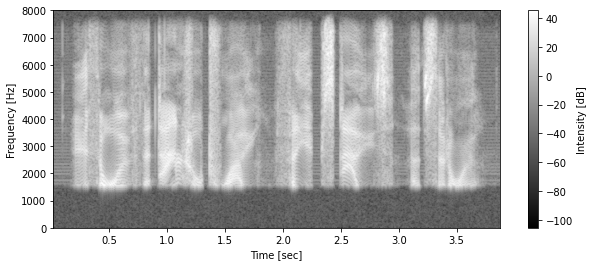

In [106]:
fig=plt.figure(figsize=(10,4))
spectrum,freqs,t,im=plt.specgram(data_post,NFFT=512,noverlap=512/16*15,Fs=wav.getframerate(),cmap="gray")
fig.colorbar(im).set_label("Intensity [dB]")
plt.xlabel("Time [sec]")
plt.ylabel("Frequency [Hz]")
plt.savefig("./spectrogram.png")
plt.show()

### スペクトルサブトラクションによる雑音抑制
音声の振幅成分を変化させて雑音を除去する方法.位相は変化させない.  
(雑音を除去したあとの位相は元々の音声の位相をそのまま使う)  
  
入力信号の振幅成分もしくは音量成分から雑音成分を引くことで、雑音成分を抑制する.

$$
|s_{lk}|\approx \sqrt[p]{\max(|x_{lk}|^p-\alpha|n_{lk}|^p,\epsilon)}
$$

$p$は1もしくは2に設定することが一般的.  
$\alpha$はスペクトルサブトラクションと呼び、どのくらい雑音成分を抑制するかを制御するパラメータ.  
$|n_{lk}|$は雑音の振幅.雑音のみ存在する時間があれば、その時間のマイクロフォン入力信号の情報から雑音の振幅を次のように推定できる.
$$
|n_{lk}|=\sqrt{\frac{1}{|\Omega_{n}|}\sum_{l\in\Omega_n}|x_{lk}|^2}
$$
スペクトルサブトラクション後の信号の位相成分は、入力信号と同じものを使う.したがって、
$$
\exp(j\phi(x_{lk}))=\frac{x_{lk}}{|x_{lk}|}
$$
ということを利用して、
$$
\hat{s}_{lk}=|s_{lk}|\frac{x_{lk}}{|x_{lk}|}
$$
で推定する.

元の音声の再生開始
雑音を混ぜた音声の再生開始


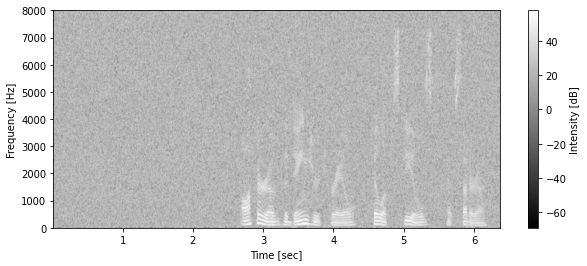

スペクトルサブトラクション済みの音声の再生開始


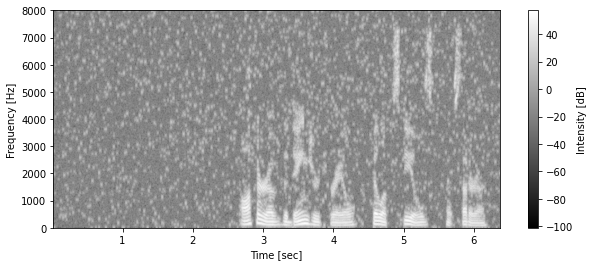

In [10]:
import scipy.signal as sp
import numpy as np 
import wave
import matplotlib.pyplot as plt 
import sounddevice as sd

np.random.seed(0)   # 乱数の種を設定
sample_wave_file="./CMU_ARCTIC/cmu_us_aew_arctic/wav/arctic_a0001.wav"  # 読み込むサンプルファイル
wav=wave.open(sample_wave_file) # ファイルを読み込む
speech_signal=wav.readframes(wav.getnframes())  # PCM形式の波形データを読み込み
speech_signal=np.frombuffer(speech_signal, dtype=np.int16)  # speech_signalを2バイトの数値列に変換

# 元の音声を再生
sd.play(speech_signal,wav.getframerate())
print("元の音声の再生開始")
status=sd.wait()

n_speech=wav.getnframes()   # 音声区間の長さを取る
sampling_rate=wav.getframerate()    # サンプリングレートを取る
n_noise_only=40000  # 雑音だけの区間のサンプル数 
n_sample=n_speech+n_noise_only  # 全体の長さ
wgn_signal=np.random.normal(scale=0.04,size=n_sample)   # 白色雑音を生成
wgn_signal=wgn_signal*np.iinfo(np.int16).max    # 2バイトのデータとして書き込むためスケールを調整
wgn_signal=wgn_signal.astype(np.int16)  # 2バイトのデータに変換

# 白色雑音を混ぜる
mix_signal=wgn_signal
mix_signal[n_noise_only:]+=speech_signal

# 雑音の混ざった音声を再生
sd.play(mix_signal,wav.getframerate())
print("雑音を混ぜた音声の再生開始")
status=sd.wait()

# 雑音の混ざった音声のスペクトログラムを表示
fig=plt.figure(figsize=(10,4))
spectrum,freqs,t,im=plt.specgram(mix_signal,NFFT=512,noverlap=512/16*15,Fs=wav.getframerate(),cmap="gray")
fig.colorbar(im).set_label("Intensity [dB]")
plt.xlabel("Time [sec]")
plt.ylabel("Frequency [Hz]")
plt.show()

# 短時間フーリエ変換
f,t,stft_data=sp.stft(mix_signal,fs=wav.getframerate(),window='hann',nperseg=512,noverlap=256)

amp=np.abs(stft_data)   # 入力信号の振幅を取得
phase=stft_data/np.maximum(amp,1.e-20)  # 入力信号の位相を取得
n_noise_only_frame=np.sum(t<(n_noise_only/sampling_rate))   # 雑音だけの区間のフレーム数

# スペクトルサブトラクションのパラメータ
p=1.0
alpha=2.0

# 雑音の振幅を推定
noise_amp=np.power(np.mean(np.power(amp,p)[:,:n_noise_only_frame],axis=1,keepdims=True),1./p)

eps=0.01*np.power(amp,p)    # 入力信号の振幅の1％を下回らないようにする

# 出力信号の振幅を計算する
processed_amp=np.power(np.maximum(np.power(amp,p)-alpha*np.power(noise_amp,p),eps), 1./p)

# 出力信号の振幅に入力信号の位相を掛ける
processed_stft_data=processed_amp*phase

# 時間領域の波形に戻す
t,processed_data_post=sp.istft(processed_stft_data,window='hann',nperseg=512,noverlap=256,fs=wav.getframerate())

# 雑音を抑制した音声を再生
sd.play(processed_data_post,wav.getframerate())
print("スペクトルサブトラクション済みの音声の再生開始")
status=sd.wait()

# 雑音を抑制した音声のスペクトログラムを表示
fig=plt.figure(figsize=(10,4))
spectrum,freqs,t,im=plt.specgram(processed_data_post,NFFT=512,noverlap=512/16*15,Fs=wav.getframerate(),cmap="gray")
fig.colorbar(im).set_label("Intensity [dB]")
plt.xlabel("Time [sec]")
plt.ylabel("Frequency [Hz]")
plt.show()

wav.close()

### ウィナーフィルタによる雑音抑制
ウィナーフィルタは入力信号に実数の係数$r_{lk}$を掛けることで出力信号を得る.
$$
\hat{s}_{lk}=r_{lk}x_{lk}
$$
係数$r_{lk}$は次のように設定する.
$$
r_{lk}=\frac{|s_{lk}|^2}{|s_{lk}|^2+\mu|n_{lk}|^2}
$$
ここで、
$$
|s_{lk}|^2=\max(|x_{lk}|^2-\alpha|n_{lk}|^2,\epsilon)
$$
で推定する.$\mu$を大きい値にすることで雑音抑制量を増やすことができる.

元の音声の再生開始
雑音を混ぜた音声の再生開始


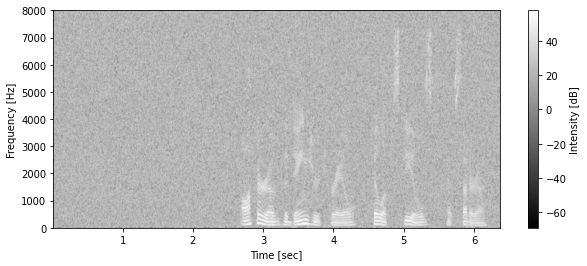

ウィナーフィルタ済みの音声の再生開始


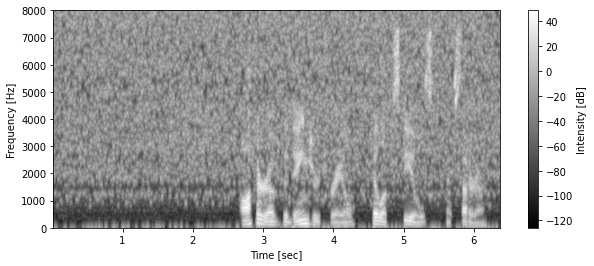

In [17]:
import scipy.signal as sp
import numpy as np 
import wave
import matplotlib.pyplot as plt 
import sounddevice as sd

np.random.seed(0)   # 乱数の種を設定
sample_wave_file="./CMU_ARCTIC/cmu_us_aew_arctic/wav/arctic_a0001.wav"  # 読み込むサンプルファイル
wav=wave.open(sample_wave_file) # ファイルを読み込む
speech_signal=wav.readframes(wav.getnframes())  # PCM形式の波形データを読み込み
speech_signal=np.frombuffer(speech_signal, dtype=np.int16)  # speech_signalを2バイトの数値列に変換

# 元の音声を再生
sd.play(speech_signal,wav.getframerate())
print("元の音声の再生開始")
status=sd.wait()

n_speech=wav.getnframes()   # 音声区間の長さを取る
sampling_rate=wav.getframerate()    # サンプリングレートを取る
n_noise_only=40000  # 雑音だけの区間のサンプル数 
n_sample=n_speech+n_noise_only  # 全体の長さ
wgn_signal=np.random.normal(scale=0.04,size=n_sample)   # 白色雑音を生成
wgn_signal=wgn_signal*np.iinfo(np.int16).max    # 2バイトのデータとして書き込むためスケールを調整
wgn_signal=wgn_signal.astype(np.int16)  # 2バイトのデータに変換

# 白色雑音を混ぜる
mix_signal=wgn_signal
mix_signal[n_noise_only:]+=speech_signal

# 雑音の混ざった音声を再生
sd.play(mix_signal,wav.getframerate())
print("雑音を混ぜた音声の再生開始")
status=sd.wait()

# 短時間フーリエ変換
f,t,stft_data=sp.stft(mix_signal,fs=wav.getframerate(),window='hann',nperseg=512,noverlap=256)

# 雑音の混ざった音声のスペクトログラムを表示
fig=plt.figure(figsize=(10,4))
spectrum,freqs,t,im=plt.specgram(mix_signal,NFFT=512,noverlap=512/16*15,Fs=wav.getframerate(),cmap="gray")
fig.colorbar(im).set_label("Intensity [dB]")
plt.xlabel("Time [sec]")
plt.ylabel("Frequency [Hz]")
plt.show()

# 入力信号の振幅を取得
amp=np.abs(stft_data)

# 入力信号のパワー（振幅の2乗）を取得
input_power=np.power(amp,2.0)

# 雑音だけの区間のフレーム数
n_noise_only_frame=np.sum(t<(n_noise_only/sampling_rate))

# ウィナーフィルタのパラメータ
alpha=1.0
mu=10

# 雑音のパワー（振幅の2乗）を推定
noise_power=np.mean(np.power(amp,2.0)[:,:n_noise_only_frame],axis=1,keepdims=True)

# 入力信号の音量の1％を下回らないようにする
eps=input_power*0.01

# 出力信号のパワー（振幅の2乗）を計算する
processed_power=np.maximum(input_power-alpha*noise_power,eps)

# 比率r_lk
wf_ratio=processed_power/(processed_power+mu*noise_power)

# 入力信号に比率を掛ける
processed_stft_data=wf_ratio*stft_data

# 時間領域の波形に戻す
t,processed_data_post=sp.istft(processed_stft_data,window='hann',nperseg=512,noverlap=256,fs=wav.getframerate())

# 雑音を抑制した音声を再生
sd.play(processed_data_post,wav.getframerate())
print("ウィナーフィルタ済みの音声の再生開始")
status=sd.wait()

# 雑音を抑制した音声のスペクトログラムを表示
fig=plt.figure(figsize=(10,4))
spectrum,freqs,t,im=plt.specgram(processed_data_post,NFFT=512,noverlap=512/16*15,Fs=wav.getframerate(),cmap="gray")
fig.colorbar(im).set_label("Intensity [dB]")
plt.xlabel("Time [sec]")
plt.ylabel("Frequency [Hz]")
plt.show()

wav.close()